In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import skimage
#%matplotlib inline
%pylab inline
import os
import sys
from time import time
from glob import glob
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration, run

Populating the interactive namespace from numpy and matplotlib


In [2]:
stack = 'MD589'
fp = os.path.join(os.environ['ROOT_DIR'], 'CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
with open(fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}

In [3]:
fname = os.path.join(os.environ['ROOT_DIR'], 'CSHL_data_processed', stack, 'All_patch_locations.pkl')
all_patch_locations = pickle.load(open(fname, 'rb'), encoding='latin1')

In [4]:
fname = os.path.join(os.environ['ROOT_DIR'], 'CSHL_data_processed', stack, 'Annotation.npy')
annotation = np.load(fname, allow_pickle = True, encoding='latin1')

In [5]:
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('name')

In [6]:
contours.head()

,name,section,vertices
0,VCA,367,"[[7476.17555322816, 7984.977043818117], [7316...."
1,IO,260,"[[10135.947729853007, 10933.270657973084], [99..."
2,LRt,286,"[[11989.668055220041, 11086.806412829588], [11..."
3,LRt,276,"[[11805.602660507782, 10950.894932558649], [11..."
4,SC,202,"[[4068.2608695651943, 3084.434782608698], [398..."


In [7]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y

In [8]:
def features_extractor(patch,params):
    extractor=patch_extractor(patch,params)
    tile=patch #cv2.imread(patch,0)
    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    extracted = []
    if _std < min_std:
        extracted.append([0] * 201)
    else:
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for k in range(origin.shape[1]):
            x, y = CDF(origin[:,k])
            ten = [x[np.argmin(np.absolute(y-0.1*(j+1)))] for j in range(10)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]/100])
    return extracted

In [9]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

In [10]:
yamlfile=os.environ['REPO_DIR']+'/shape_params.yaml'
params=configuration(yamlfile).getParams()
print(params)

{'name': 'local', 'paths': {'s3stem': 's3://mousebraindata-open/MD657', 'patches': 'permuted', 'DiffusionMap': '/Users/kuiqian/Github/shapeology_code/notebooks/diffusionMap', 'scripts_dir': '/Users/kuiqian/Github//shapeology_code/scripts', 'data_dir': '/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/'}, 'preprocessing': {'polarity': -1, 'min_std': 10, 'offset': -20, 'min_area': 10}, 'normalization': {'size_thresholds': [15, 51, 201]}}


/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [11]:
paired_structures = ['5N', '6N', '7N', '7nn', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures
stack = 'MD589'
cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patches_features/MD589/'
raw_images_root = os.environ['ROOT_DIR']+'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
savepath = os.environ['ROOT_DIR']+'CSHL_hsv/'
if not os.path.exists(savepath):
    os.mkdir(savepath)
savepath = savepath+stack+'/'
if not os.path.exists(savepath):
    os.mkdir(savepath)

resol = 0.46
half_size = 112

In [100]:
t0=time()
for structure in all_structures:  
    t1=time()
    subpath = savepath+structure+'/'
    if not os.path.exists(subpath):
        os.mkdir(subpath)
    else:
        continue
    fp =[]
    fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
    fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state],'rb'))
        features.extend(np.array(clouds))
        labels.extend([1-state]*len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train = features
    y_train = labels
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure=='7nn':
        structure = '7n'

    negative = structure+'_surround_500um_noclass'
    
    polygons = [(contour['section'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(structure).iterrows() ]

    for contour_id, contour in polygons:
        section = contour_id
        polygon = contour.copy()
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        m, n = img.shape
        [left, right, up, down] = [int(max(min(all_patch_locations[negative][section][:,0])-half_size,0)), 
                                   int(min(np.ceil(max(all_patch_locations[negative][section][:,0])+half_size),n-1)),
                                   int(max(min(all_patch_locations[negative][section][:,1])-half_size,0)), 
                                   int(min(np.ceil(max(all_patch_locations[negative][section][:,1])+half_size),m-1))]

        xs, ys = np.meshgrid(np.arange(left+half_size, right-half_size+1, half_size*2), np.arange(up+half_size, down-half_size+1, half_size*2), indexing='xy')
        locations = np.c_[xs.flat, ys.flat]
        inside = all_patch_locations[structure][section]
        all_rows = locations.view([('', locations.dtype)] * locations.shape[1])
        inside_rows = inside.view([('', inside.dtype)] * inside.shape[1])
        outside = np.setdiff1d(all_rows, inside_rows).view(locations.dtype).reshape(-1, locations.shape[1])
        windows = []
        windows.append(inside)
        windows.append(outside)
        polygon[:,0] = polygon[:,0]-left
        polygon[:,1] = polygon[:,1]-up
        
        hsv = np.zeros([down-up+1, right-left+1,3])
        hsv[:,:,2] = 1
        for state in range(2):
            #structure = structures[state]
            for index in range(len(windows[state])):
                try:
                    x = int( float( windows[state][index][0] ) )
                    y = int( float( windows[state][index][1] ) )
                    patch = img[y-half_size:y+half_size,x-half_size:x+half_size]
                    extracted = features_extractor(patch, params)
                    xtest=xgb.DMatrix(extracted)
                    score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
                    value_img = patch/255
                    hsv[y-half_size-up:y+half_size-up, x-half_size-left:x+half_size-left,2] = value_img
                    satua_img = np.zeros_like(value_img)+score
                    origin = hsv[y-half_size-up:y+half_size-up, x-half_size-left:x+half_size-left,1]
                    comp = np.absolute(origin)-np.absolute(satua_img)
                    hsv[y-half_size-up:y+half_size-up, x-half_size-left:x+half_size-left,1] = origin*(comp>0)+satua_img*(comp<0)
                except:
                    continue
        hsv[:,:,0] = (hsv[:,:,1]<0)*0.66 + (hsv[:,:,1]>0)*1.0
        hsv[:,:,1] = np.absolute(hsv[:,:,1])
        hsv[:,:,1] = (hsv[:,:,1]-hsv[:,:,1].min())/(hsv[:,:,1].max()-hsv[:,:,1].min())*0.8+0.2
        rgb = skimage.color.hsv2rgb(hsv)
        rgb=rgb*255
        rgb=rgb.astype(np.uint8)
        com = cv2.polylines(rgb.copy(),[polygon.astype(np.int32)],True,[0,255,0],15,lineType=8)
        filename = subpath + structure+'_'+str(section)+'.tif'
        cv2.imwrite(filename, com)
    print(structure + ' finished in %5.1f seconds' % (time() - t1))
print('Finished in %5.1f seconds' % (time() - t0))
    

KeyboardInterrupt: 

5N finished in 121.7 seconds


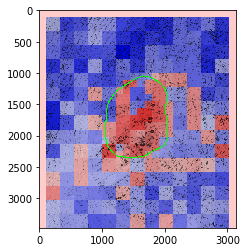

In [12]:
structure = all_structures[0]
t1=time()
fp =[]
fp.append(cell_dir+structure+'/MD589_'+structure+'_positive.pkl') 
fp.append(cell_dir+structure+'/MD589_'+structure+'_negative.pkl') 
features = []
labels = []
for state in range(2):
    clouds = pickle.load(open(fp[state],'rb'))
    features.extend(np.array(clouds))
    labels.extend([1-state]*len(clouds))
features = np.array(features)
labels = np.array(labels)
X_train = features
y_train = labels
dtrain = xgb.DMatrix(X_train, label=y_train)
bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

negative = structure+'_surround_500um_noclass'

polygons = [(contour['section'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group(structure).iterrows() ]

for contour_id, contour in polygons:
    section = contour_id
    polygon = contour.copy()
    
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
m, n = img.shape
[left, right, up, down] = [int(max(min(all_patch_locations[negative][section][:,0])-half_size,0)), 
                           int(min(np.ceil(max(all_patch_locations[negative][section][:,0])+half_size),n-1)),
                           int(max(min(all_patch_locations[negative][section][:,1])-half_size,0)), 
                           int(min(np.ceil(max(all_patch_locations[negative][section][:,1])+half_size),m-1))]

xs, ys = np.meshgrid(np.arange(left, right+1, half_size*2), np.arange(up, down+1, half_size*2), indexing='xy')
locations = np.c_[xs.flat, ys.flat]
inside = all_patch_locations[structure][section]
all_rows = locations.view([('', locations.dtype)] * locations.shape[1])
inside_rows = inside.view([('', inside.dtype)] * inside.shape[1])
outside = np.setdiff1d(all_rows, inside_rows).view(locations.dtype).reshape(-1, locations.shape[1])
windows = []
windows.append(inside)
windows.append(outside)
polygon[:,0] = polygon[:,0]-left
polygon[:,1] = polygon[:,1]-up

hsv = np.zeros([down-up+1, right-left+1,3])
hsv[:,:,2] = 1
for state in range(2):
    for index in range(len(windows[state])):
        try:
            x = int( float( windows[state][index][0] ) )
            y = int( float( windows[state][index][1] ) )
            patch = img[y-half_size:y+half_size,x-half_size:x+half_size].copy()
            extracted = features_extractor(patch, params)
            xtest=xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            value_img = patch/255
            hsv[y-half_size-up:y+half_size-up, x-half_size-left:x+half_size-left,2] = value_img
            satua_img = np.zeros_like(value_img)+score
            origin = hsv[y-half_size-up:y+half_size-up, x-half_size-left:x+half_size-left,1]
            comp = np.absolute(origin)-np.absolute(satua_img)
            hsv[y-half_size-up:y+half_size-up, x-half_size-left:x+half_size-left,1] = origin*(comp>0)+satua_img*(comp<0)
        except:
            continue
hsv[:,:,0] = (hsv[:,:,1]<0)*0.66 + (hsv[:,:,1]>0)*1.0
hsv[:,:,1] = np.absolute(hsv[:,:,1])
hsv[:,:,1] = (hsv[:,:,1]-hsv[:,:,1].min())/(hsv[:,:,1].max()-hsv[:,:,1].min())*0.8+0.2
rgb = skimage.color.hsv2rgb(hsv)
rgb=rgb*255
rgb=rgb.astype(np.uint8)
com = cv2.polylines(rgb.copy(),[polygon.astype(np.int32)],True,[0,255,0],15,lineType=8)
plt.imshow(com)
print(structure + ' finished in %5.1f seconds' % (time() - t1))

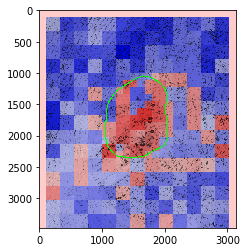

In [96]:
#polygon[:,[0,1]] = polygon[:,[1,0]]
#plt.figure()
com = cv2.polylines(rgb.copy(),[polygon.astype(np.int32)],True,[0,255,0],15,lineType=8)
plt.imshow(com)


polygons = [(cont['section'], cont['vertices']) \
                for contour_id, cont in contours_grouped.get_group(structure).iterrows() ]

for contour_id, contour in polygons:
    section = contour_id
    polygon = contour.copy()

polygon[:,0] = polygon[:,0]-left
polygon[:,1] = polygon[:,1]-up
polygon

In [121]:
scripts_dir = os.environ['REPO_DIR']
yaml_file = 'shape_params.yaml'
! python $scripts_dir/HSV.py $stack $structure $yaml_file

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))
^C


In [133]:
!aws s3 ls mousebrainatlas-data/CSHL_hsv/MD589/6N/

In [13]:
polygons = [(contour['section'], contour['vertices']) \
                for contour_id, contour in contours_grouped.get_group('4N').iterrows() ]

In [23]:
240 not in all_patch_locations['4N'].keys()

True

In [3]:
scripts_dir = os.environ['REPO_DIR']
yaml_file = 'shape_params.yaml'
! python $scripts_dir/Shape_shift.py MD594 94 $yaml_file

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_prep2_lossless_gray.tif
download: s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossl

In [ ]:
scripts_dir = os.environ['REPO_DIR']
yaml_file = 'shape_params.yaml'
! python $scripts_dir/.py MD594 104 $yaml_file

In [2]:
def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [3]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_upload_from_s3(fp, recursive=False)
fname = os.path.join('CSHL_data_processed', stack, 'All_patch_locations.pkl')
setup_upload_from_s3(fname, recursive=False)
fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_upload_from_s3(fname, recursive=False)

run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_sorted_filenames.txt s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_sorted_filenames.txt
run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/All_patch_locations.pkl s3://mousebrainatlas-data/CSHL_data_processed/MD594/All_patch_locations.pkl
run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/Annotation.npy s3://mousebrainatlas-data/CSHL_data_processed/MD594/Annotation.npy


In [22]:
objects = os.listdir(os.environ['ROOT_DIR']+'CSHL_hsv/MD589/./.')
onlyfiles = next(os.walk(os.environ['ROOT_DIR']+'CSHL_hsv/MD589/'))[2]
len(objects)

26

In [23]:
len([name for name in os.listdir(os.environ['ROOT_DIR']+'CSHL_hsv/MD589/.') if os.path.isfile(name)])

1

In [25]:
path, dirs, files = next(os.walk(os.environ['ROOT_DIR']+'CSHL_hsv/MD589/.'))
len(dirs)

25

In [28]:
import fnmatch
len(fnmatch.filter(os.listdir(os.environ['ROOT_DIR']+'CSHL_hsv/MD589/..'), '*.tif'))

0

In [35]:
cpt = sum([len(files) for r, d, files in os.walk(os.environ['ROOT_DIR']+'CSHL_hsv/MD594/')])

In [36]:
cpt

0.0